In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization, MaxPool2D, Dropout, Input, concatenate
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.utils import plot_model

angry


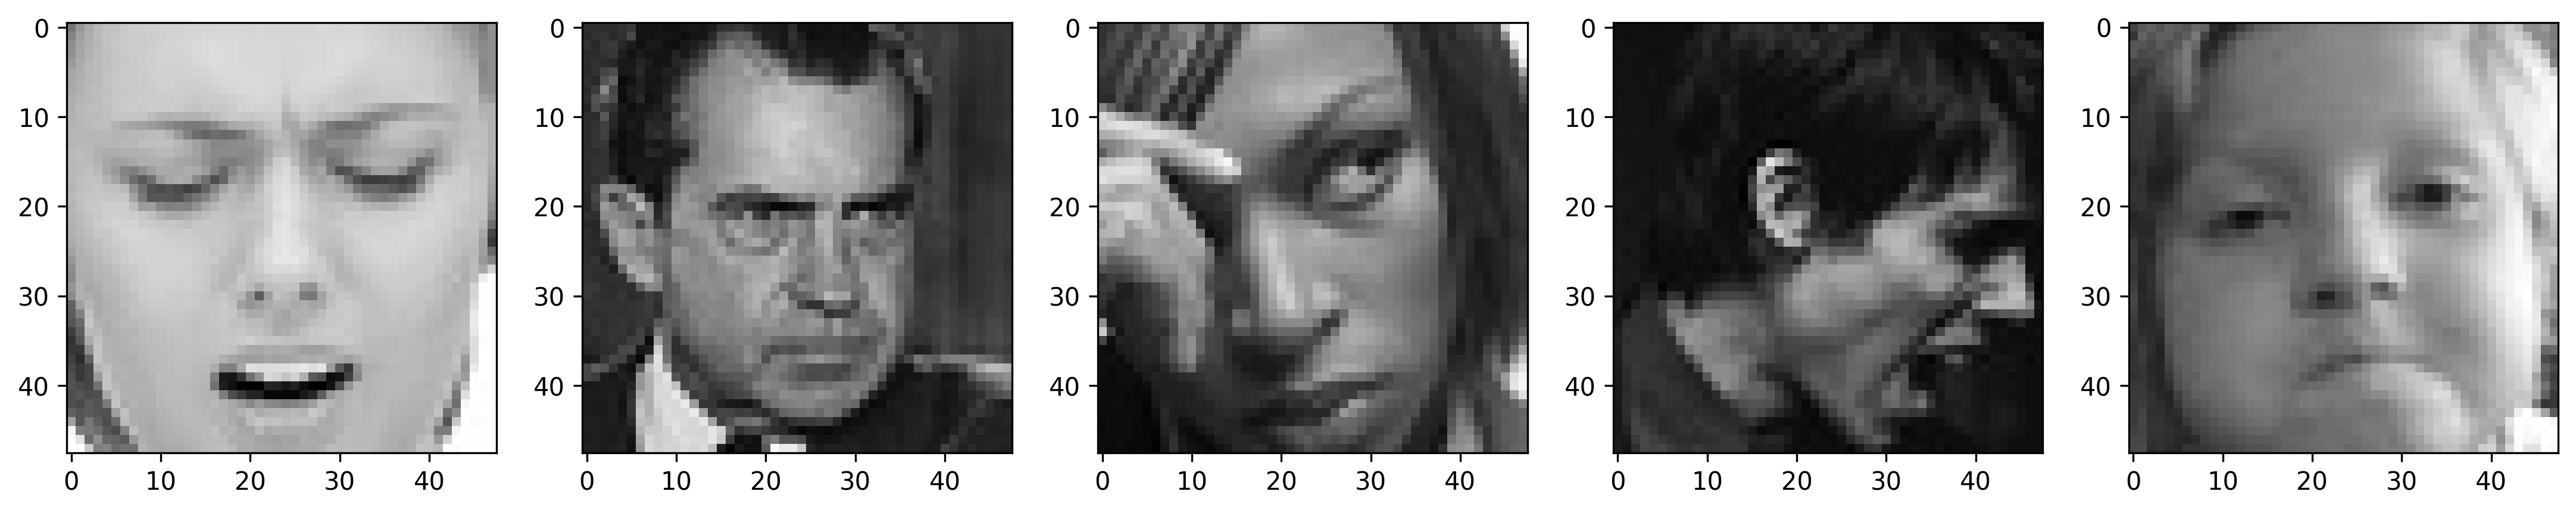

disgust


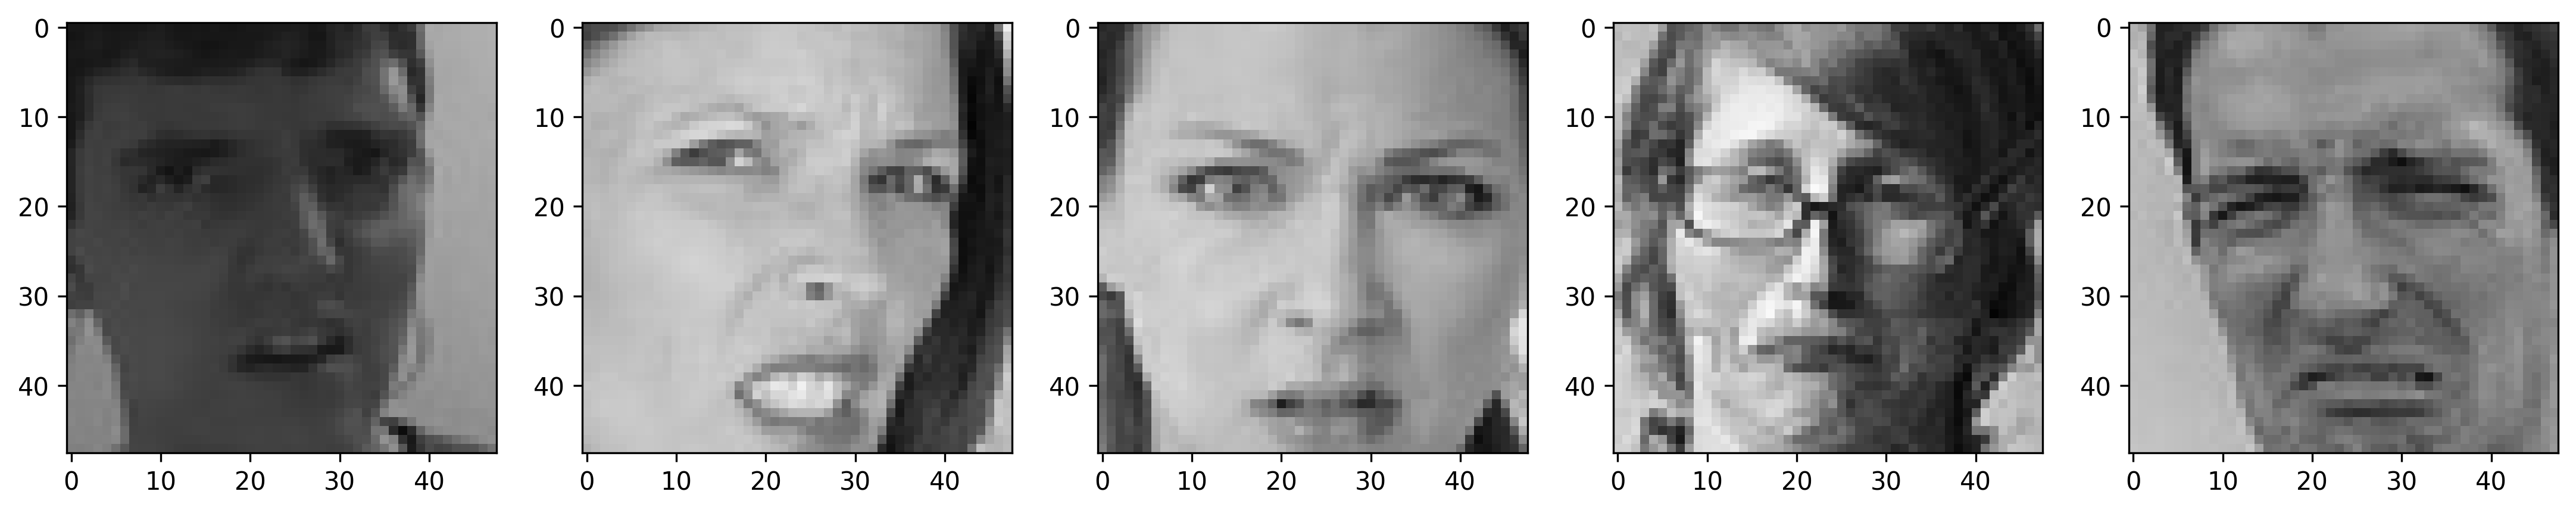

fear


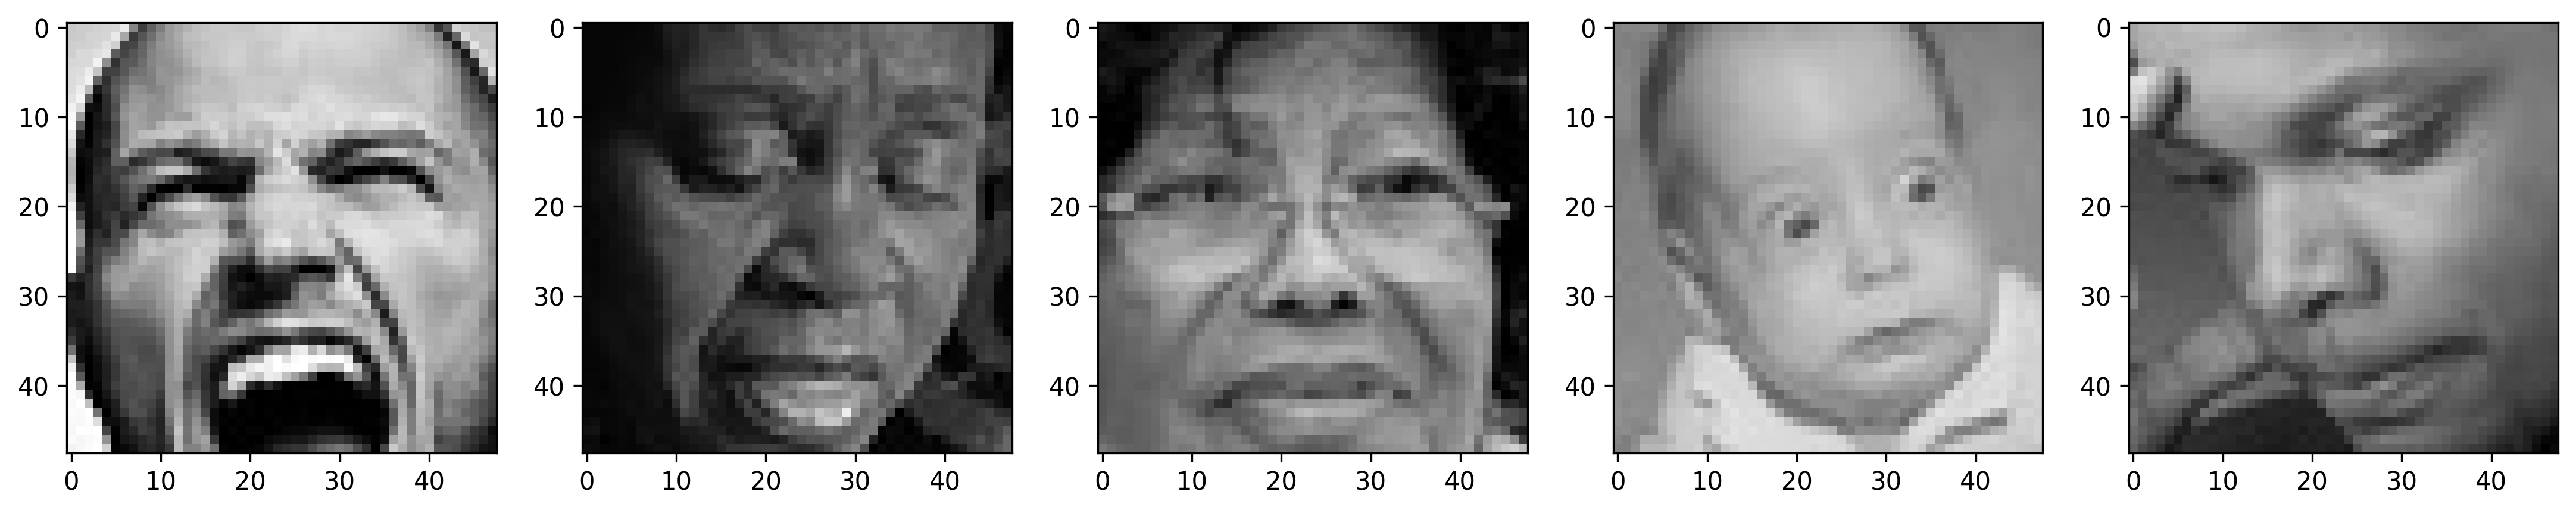

happy


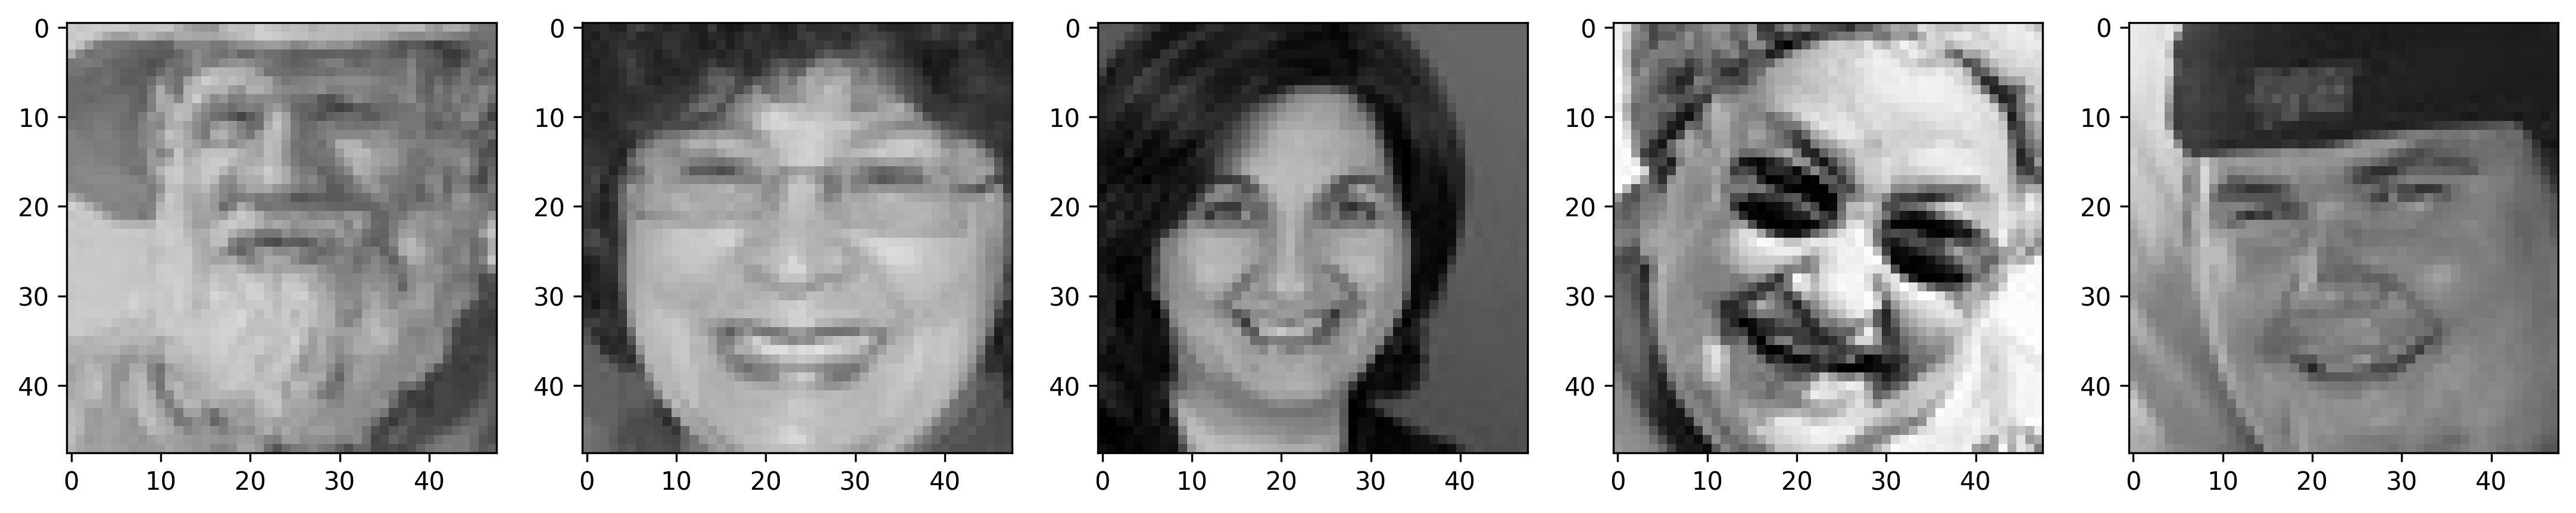

neutral


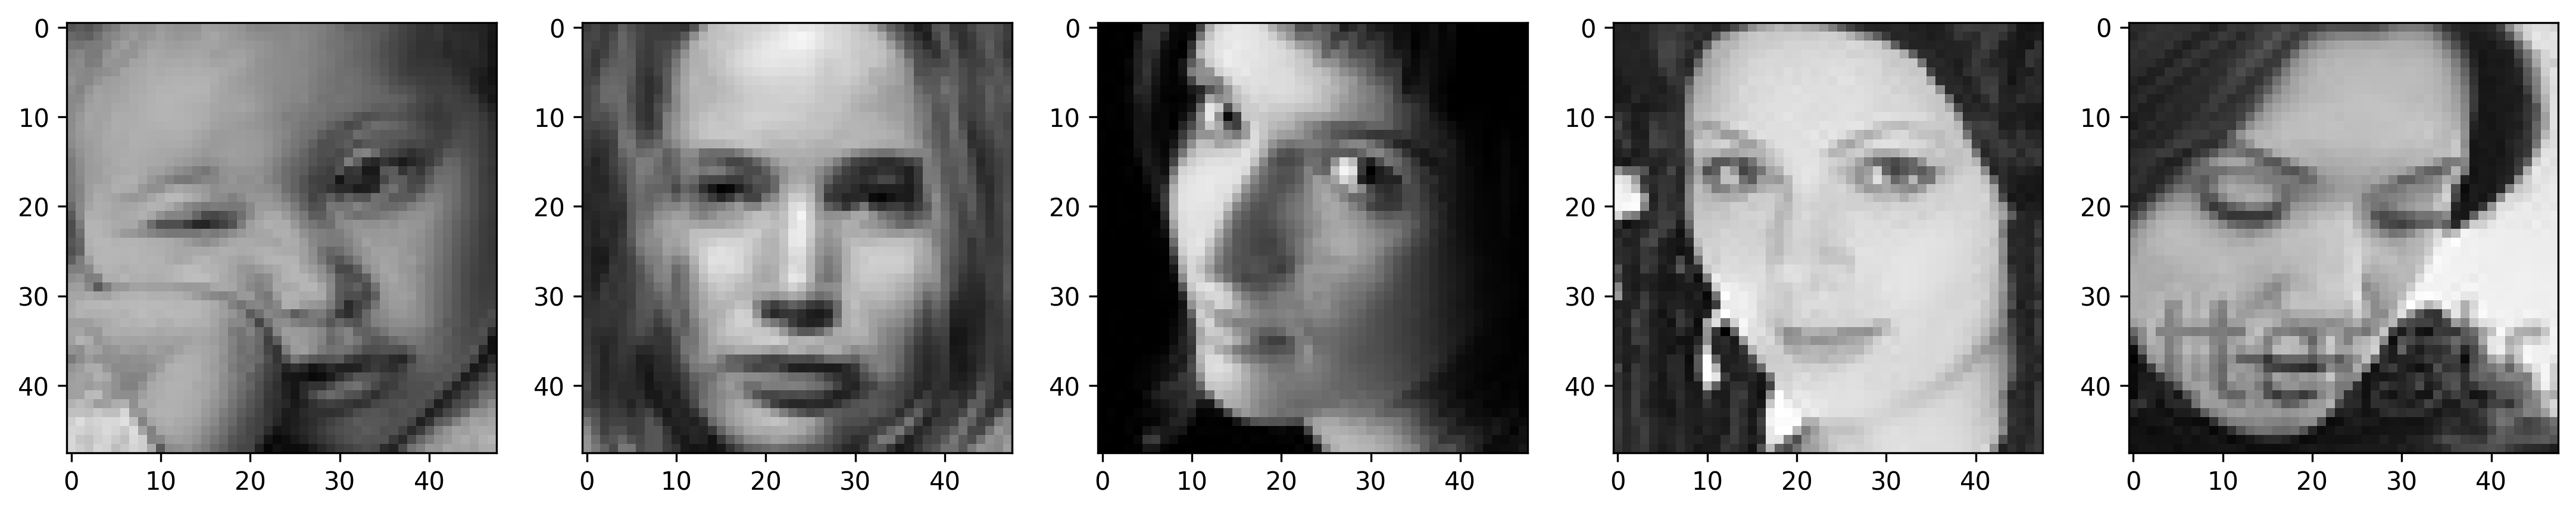

sad


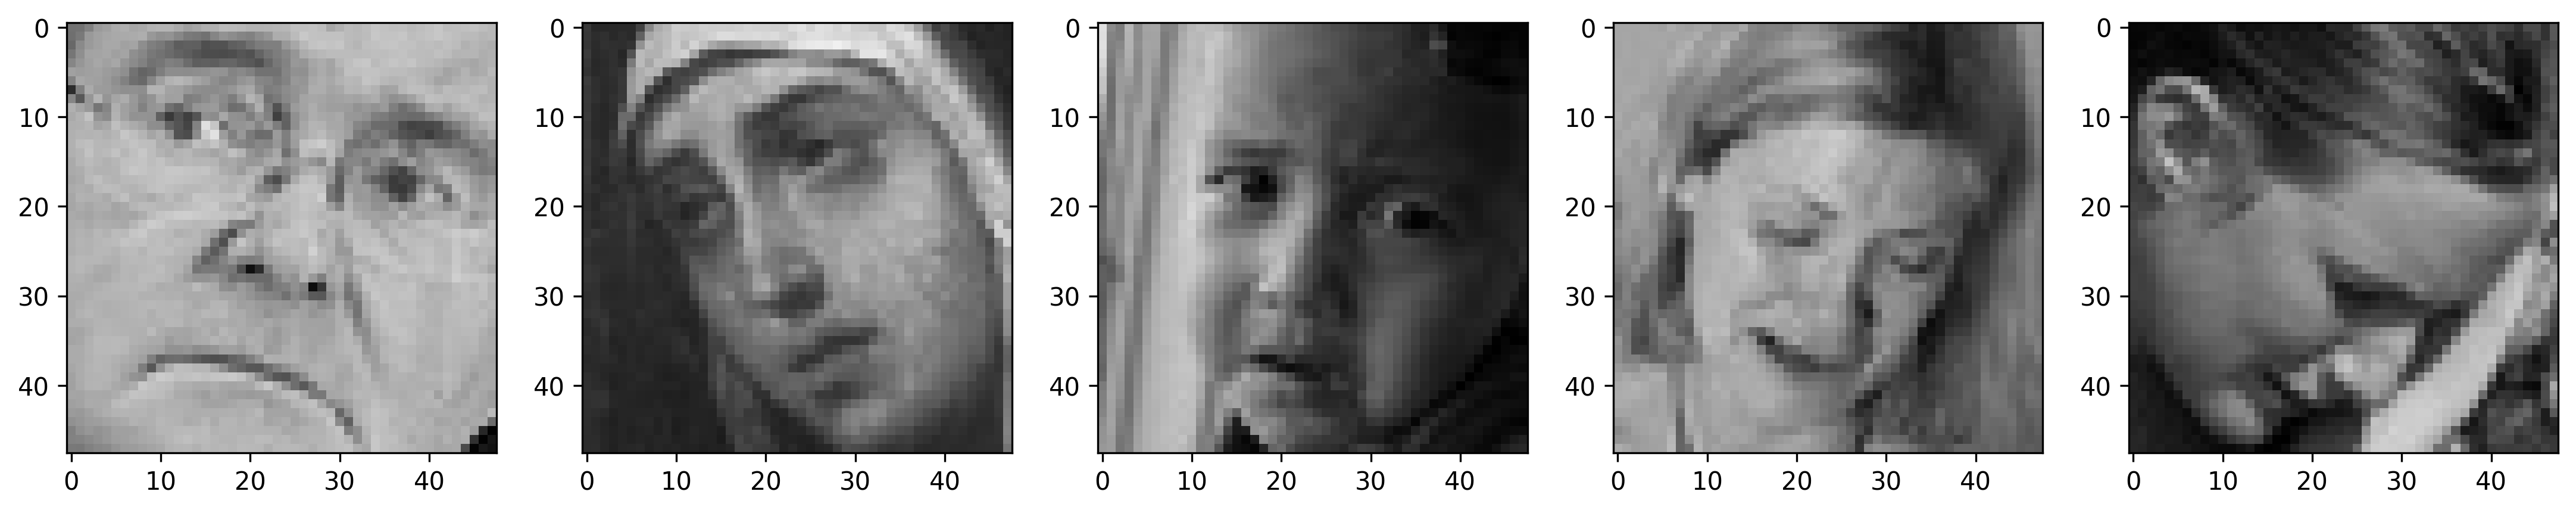

surprise


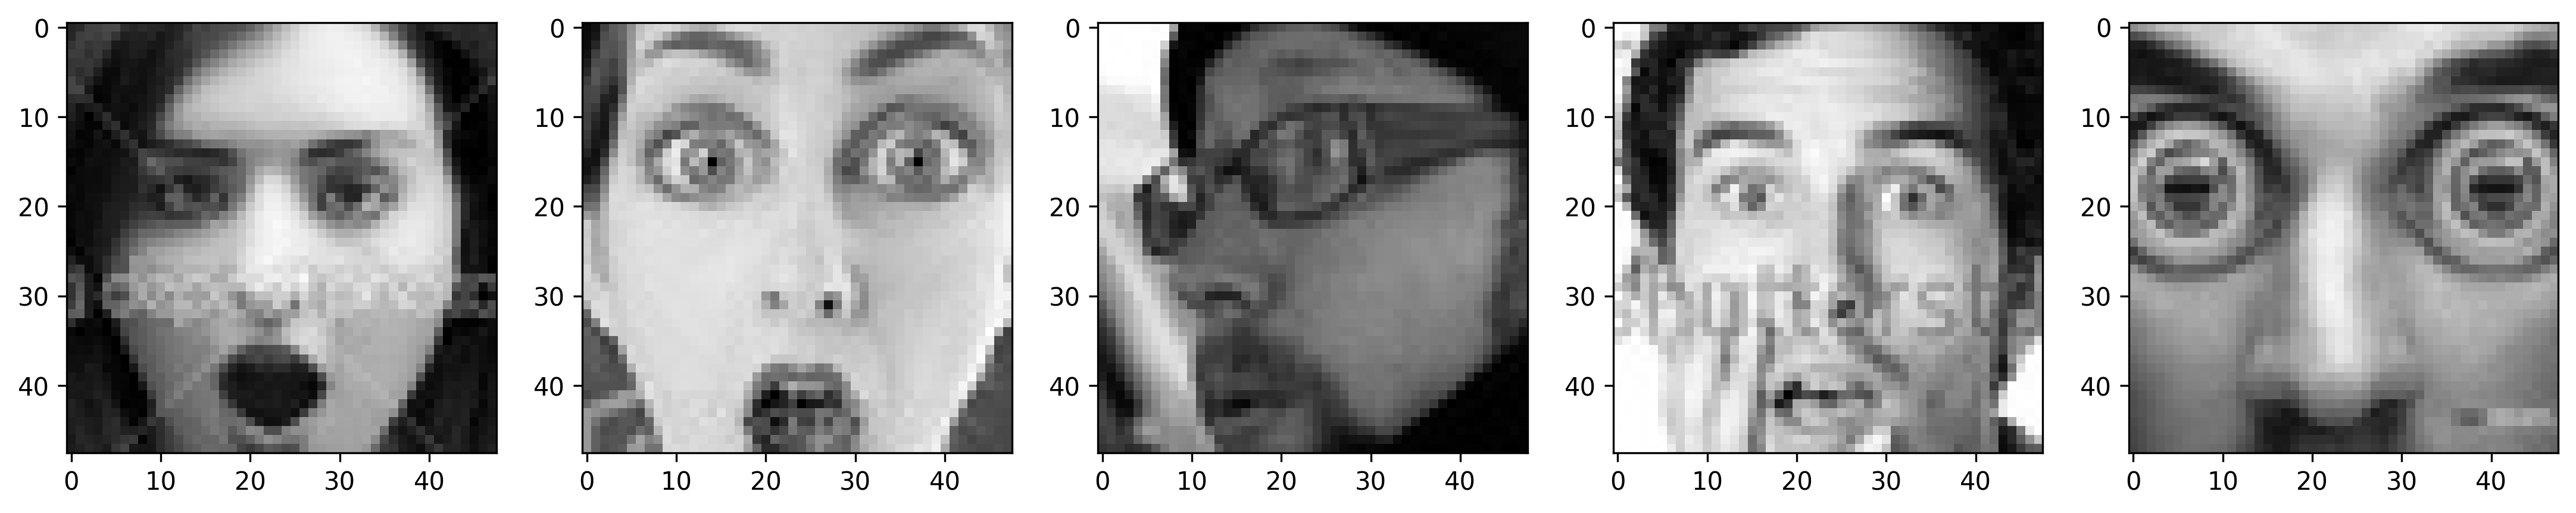

In [2]:
train_path = '../input/fer2013/train/'
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

for c in classes:
    print(c)
    #create figure layout
    figure, axes = plt.subplots(nrows=1,ncols=5, figsize=[18,6], dpi=300)
    axes = axes.ravel()
    emo_path = os.path.join(train_path, c)
    image_list = os.listdir(emo_path)[:5]

    #intaract over image list to add them into figure
    for i in range(len(axes)):
        axes[i].imshow(load_img(os.path.join(emo_path, image_list[i])))

    plt.show()

In [3]:
#inception module declaration
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    conv_1x1 = Conv2D(filters_1x1, kernel_size=(1, 1), padding='same', activation='relu')(x)

    # 3 × 3 route = 1 × 1 CONV + 3 × 3 CONV
    pre_conv_3x3 = Conv2D(filters_3x3_reduce, kernel_size=(1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, kernel_size=(3, 3), padding='same', activation='relu')(pre_conv_3x3)

    # 5 × 5 route = 1 × 1 CONV + 5 × 5 CONV
    pre_conv_5x5 = Conv2D(filters_5x5_reduce, kernel_size=(1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, kernel_size=(5, 5), padding='same', activation='relu')(pre_conv_5x5)

    # pool route = POOL + 1 × 1 CONV
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output

In [4]:
input_layer = Input(shape=(48, 48, 1))

x = Conv2D(128, (5, 5), padding='same', strides=(1, 1), activation='relu', name='conv_1_5x5/2')(input_layer)

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = BatchNormalization(axis=3)(x)

x = Conv2D(192, (1, 1), padding='same', strides=(1, 1), activation='relu')(x)

x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu')(x)
x = BatchNormalization(axis=3)(x)

x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu')(x)
x = BatchNormalization(axis=3)(x)

#inception block 1.1
x = inception_module(x, filters_1x1=64,
                     filters_3x3_reduce=96, filters_3x3=128,
                     filters_5x5_reduce=16, filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

#inception block 1.2
x = inception_module(x, filters_1x1=128,
                     filters_3x3_reduce=128, filters_3x3=192,
                     filters_5x5_reduce=32, filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
x = BatchNormalization(axis=3)(x)

x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu')(x)
x = BatchNormalization(axis=3)(x)

#inception block 2.3
x = inception_module(x, filters_1x1=128,
                     filters_3x3_reduce=128, filters_3x3=256,
                     filters_5x5_reduce=24, filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')


#inception block 3.2
x = inception_module(x, filters_1x1=384,
                     filters_3x3_reduce=192, filters_3x3=384,
                     filters_5x5_reduce=48, filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = BatchNormalization(axis=3)(x)

x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(x)


# flatten
x = Flatten()(x)

# output layer
x = Dense(units=512, activation=relu)(x)
x = Dropout(0.5)(x)
output_layer = Dense(units=7, activation=softmax)(x)

model = Model(input_layer, output_layer)
model.summary()

2022-04-23 05:17:52.063108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 05:17:52.174445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 05:17:52.175289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 05:17:52.176799: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv_1_5x5/2 (Conv2D)           (None, 48, 48, 128)  3328        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 24, 24, 128)  0           conv_1_5x5/2[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 24, 128)  512         max_pool_1_3x3/2[0][0]           
______________________________________________________________________________________________

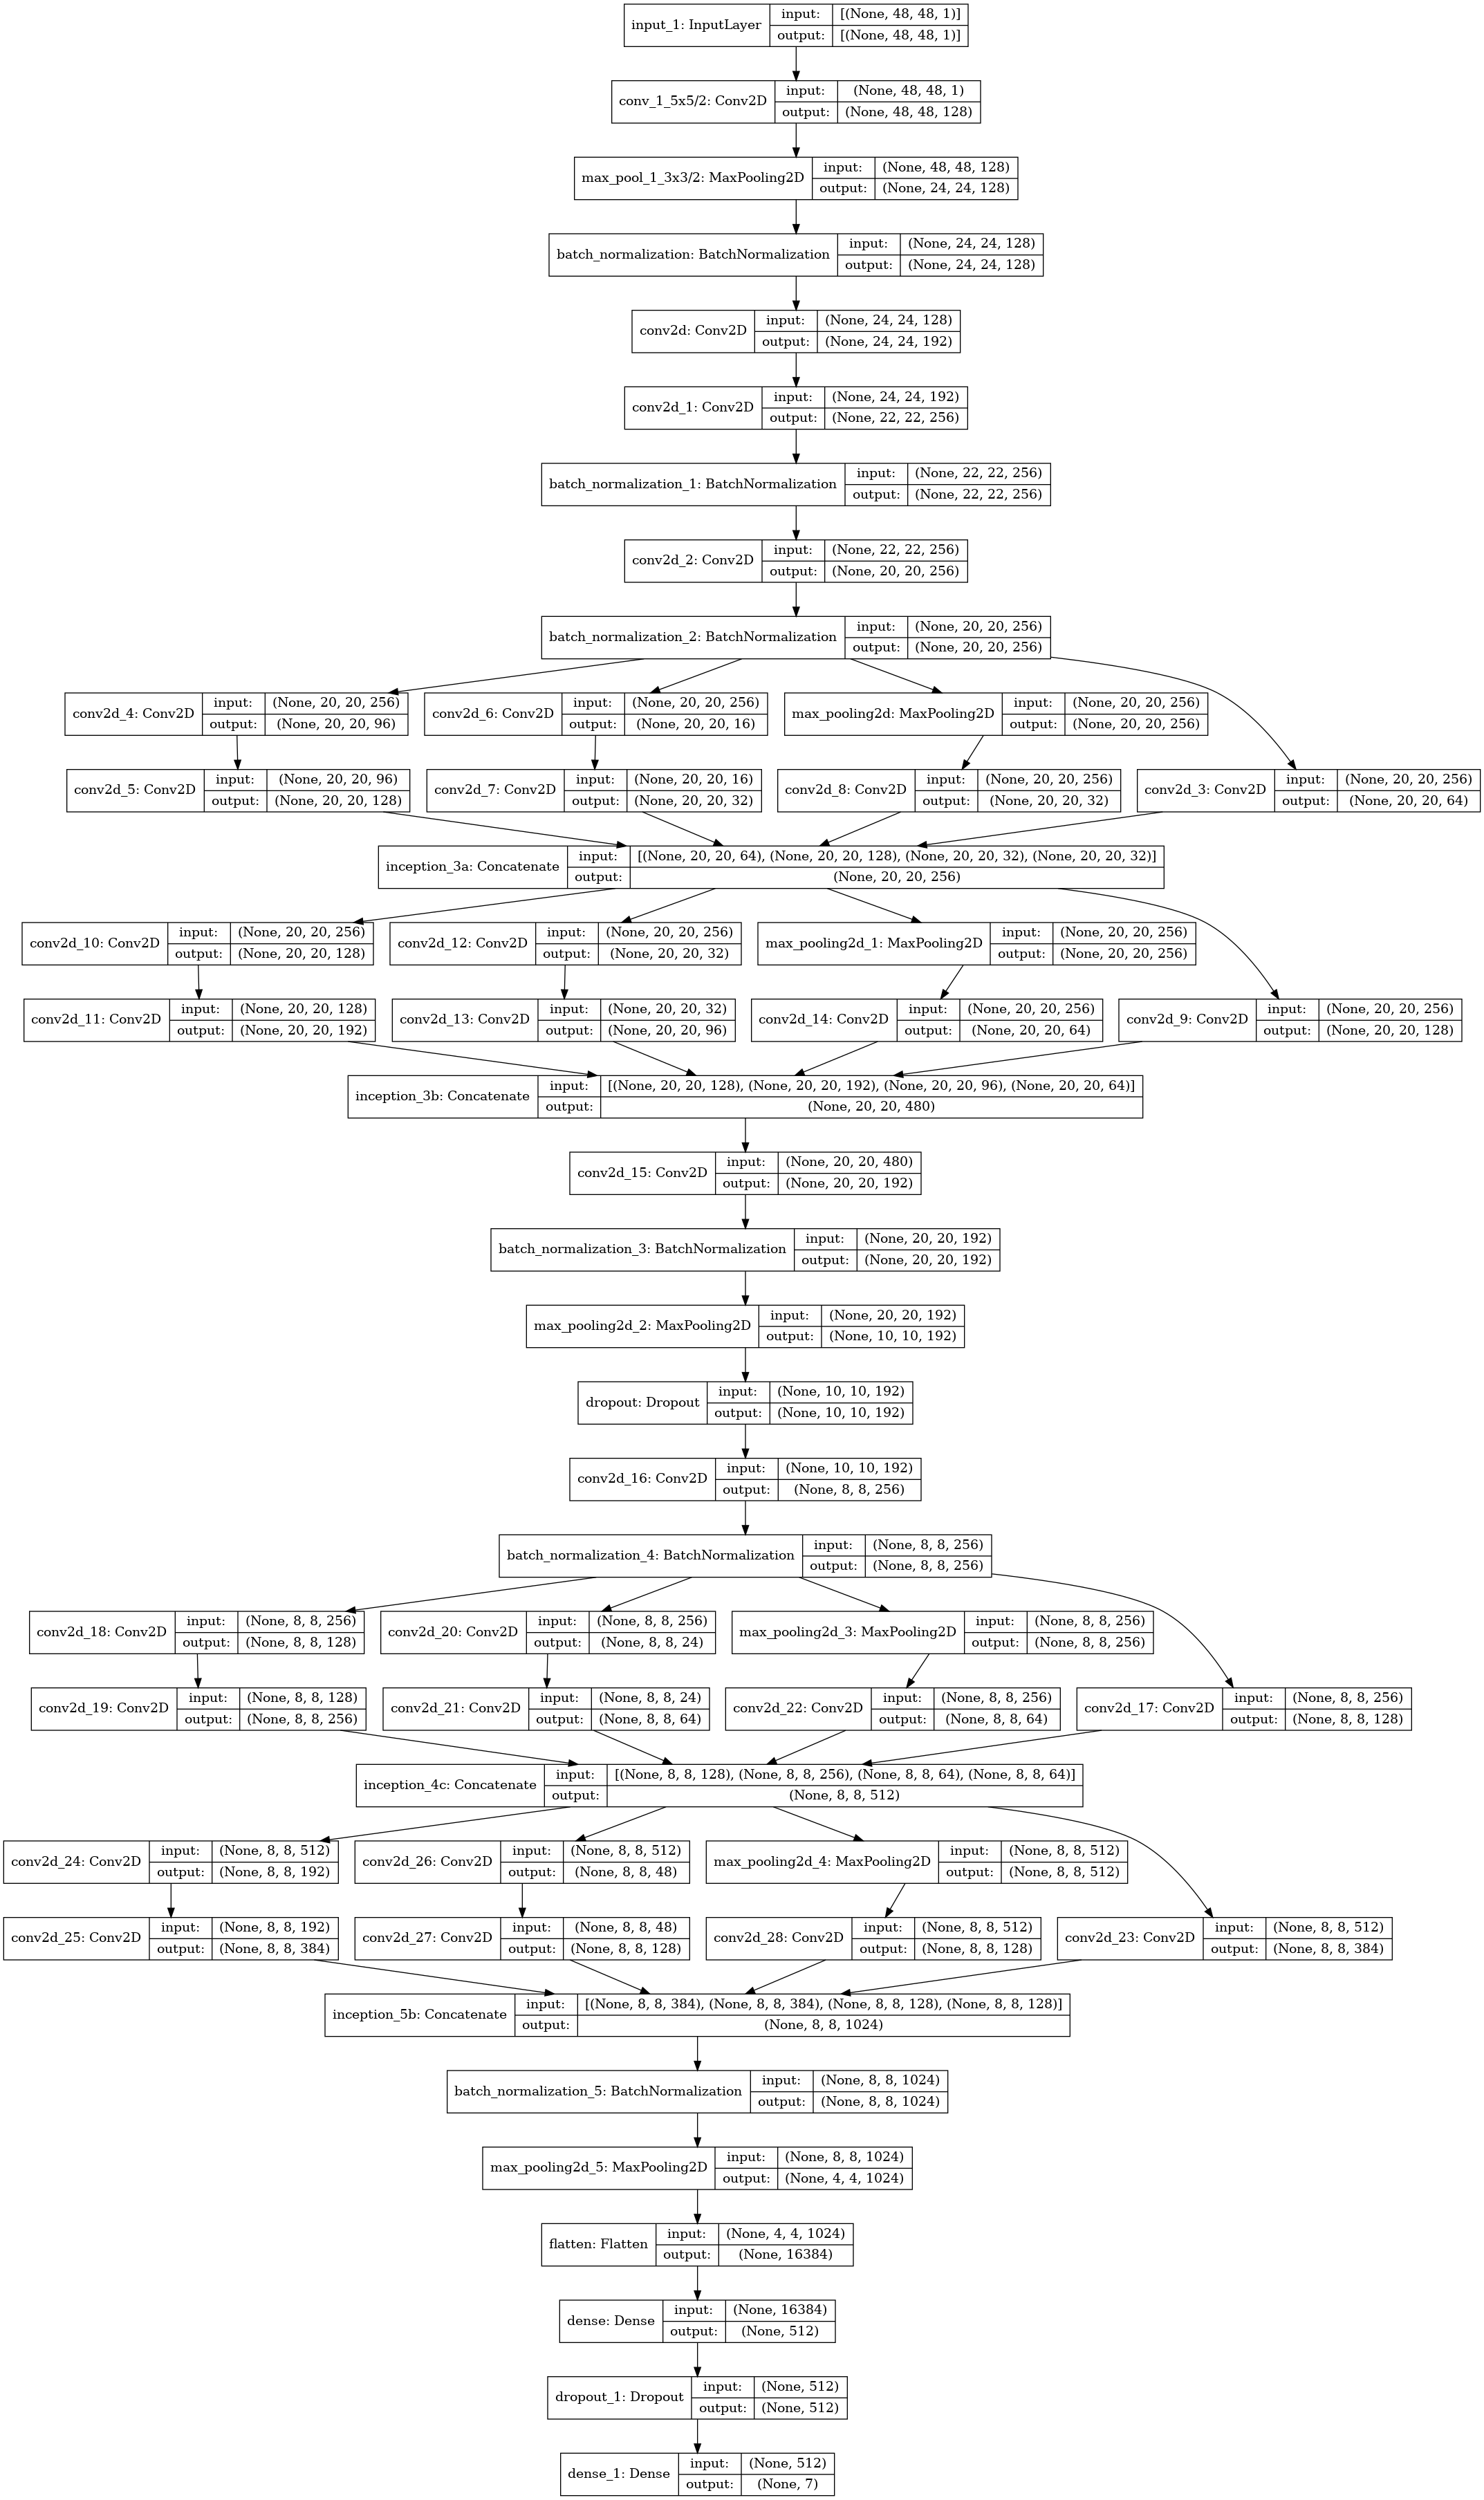

In [5]:
plot_model(model,
           show_shapes=True,
           show_layer_names=True)

In [6]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                  validation_split=0.2)

train_gen = datagen_train.flow_from_directory("../input/fer2013/train/",
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training')

validation_gen = datagen_train.flow_from_directory('../input/fer2013/train/',
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='validation')

datagen_validation = ImageDataGenerator(horizontal_flip=True)

test_gen = datagen_validation.flow_from_directory('../input/fer2013/test/',
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=2,
                              min_lr=0.00001,
                              model='auto')

check_point = ModelCheckpoint(filepath='FER_VGG.hdf5',
                              monitor='val_loss',
                              save_best_only=True,
                              mode='min',
                              verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stop]

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

In [9]:
history = model.fit(train_gen,
                      epochs=300,
                      callbacks=callbacks,
                      validation_data=validation_gen)

2022-04-23 05:18:20.111307: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300


2022-04-23 05:18:23.057117: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


359/359 [==============================] - 130s 336ms/step - loss: 2.1621 - accuracy: 0.2639 - val_loss: 1.7008 - val_accuracy: 0.3097

Epoch 00001: val_loss improved from inf to 1.70075, saving model to FER_VGG.hdf5
Epoch 2/300
359/359 [==============================] - 25s 70ms/step - loss: 1.6527 - accuracy: 0.3361 - val_loss: 1.5198 - val_accuracy: 0.3874

Epoch 00002: val_loss improved from 1.70075 to 1.51976, saving model to FER_VGG.hdf5
Epoch 3/300
359/359 [==============================] - 25s 69ms/step - loss: 1.5345 - accuracy: 0.3982 - val_loss: 1.5429 - val_accuracy: 0.3909

Epoch 00003: val_loss did not improve from 1.51976
Epoch 4/300
359/359 [==============================] - 25s 71ms/step - loss: 1.4756 - accuracy: 0.4293 - val_loss: 1.5531 - val_accuracy: 0.4003

Epoch 00004: val_loss did not improve from 1.51976
Epoch 5/300
359/359 [==============================] - 26s 71ms/step - loss: 1.3804 - accuracy: 0.4570 - val_loss: 1.2874 - val_accuracy: 0.5044

Epoch 00005:

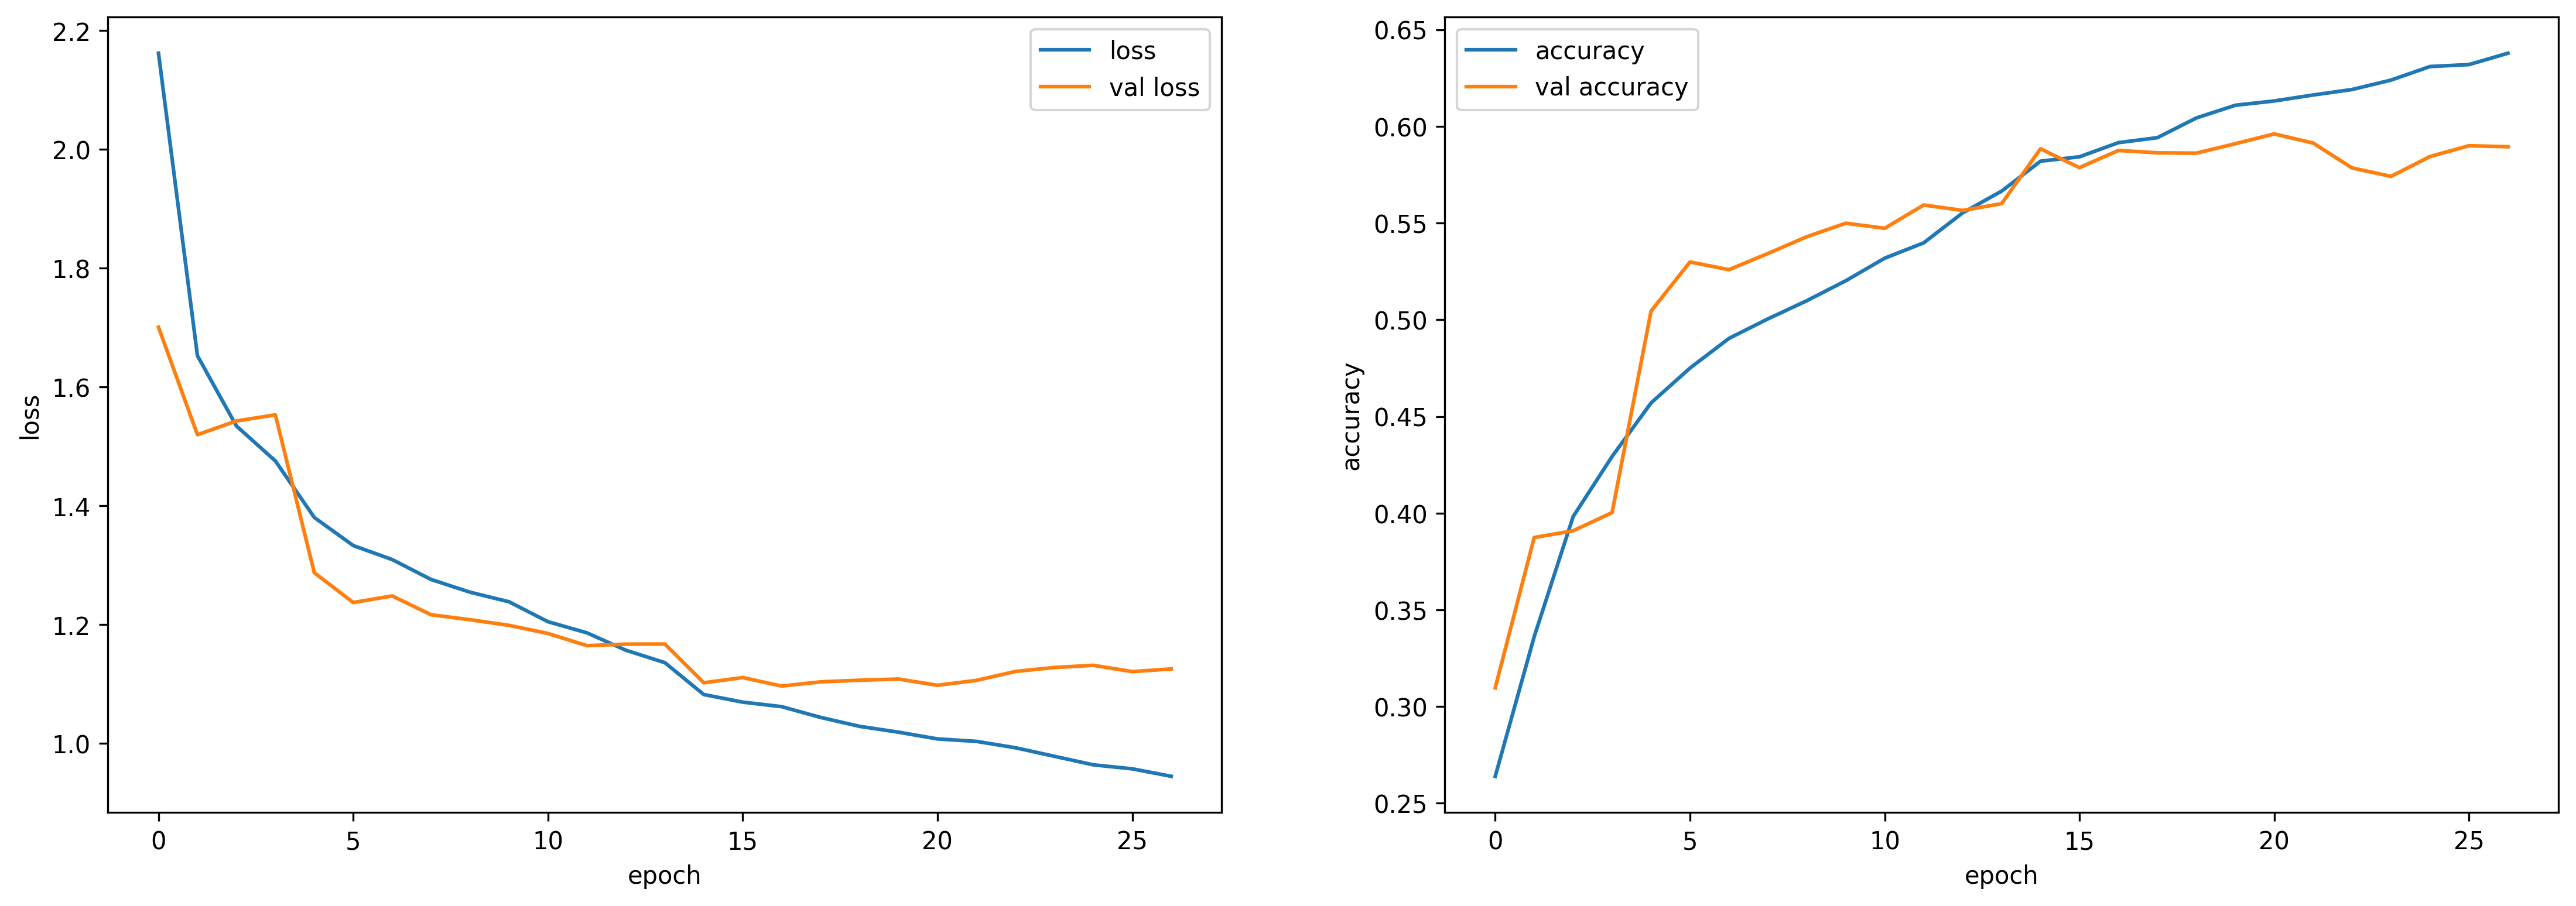

In [10]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(history.history['loss'])))

sns.lineplot(x=epochs, y=history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('FER_VGG_train_history.png')
plt.show()

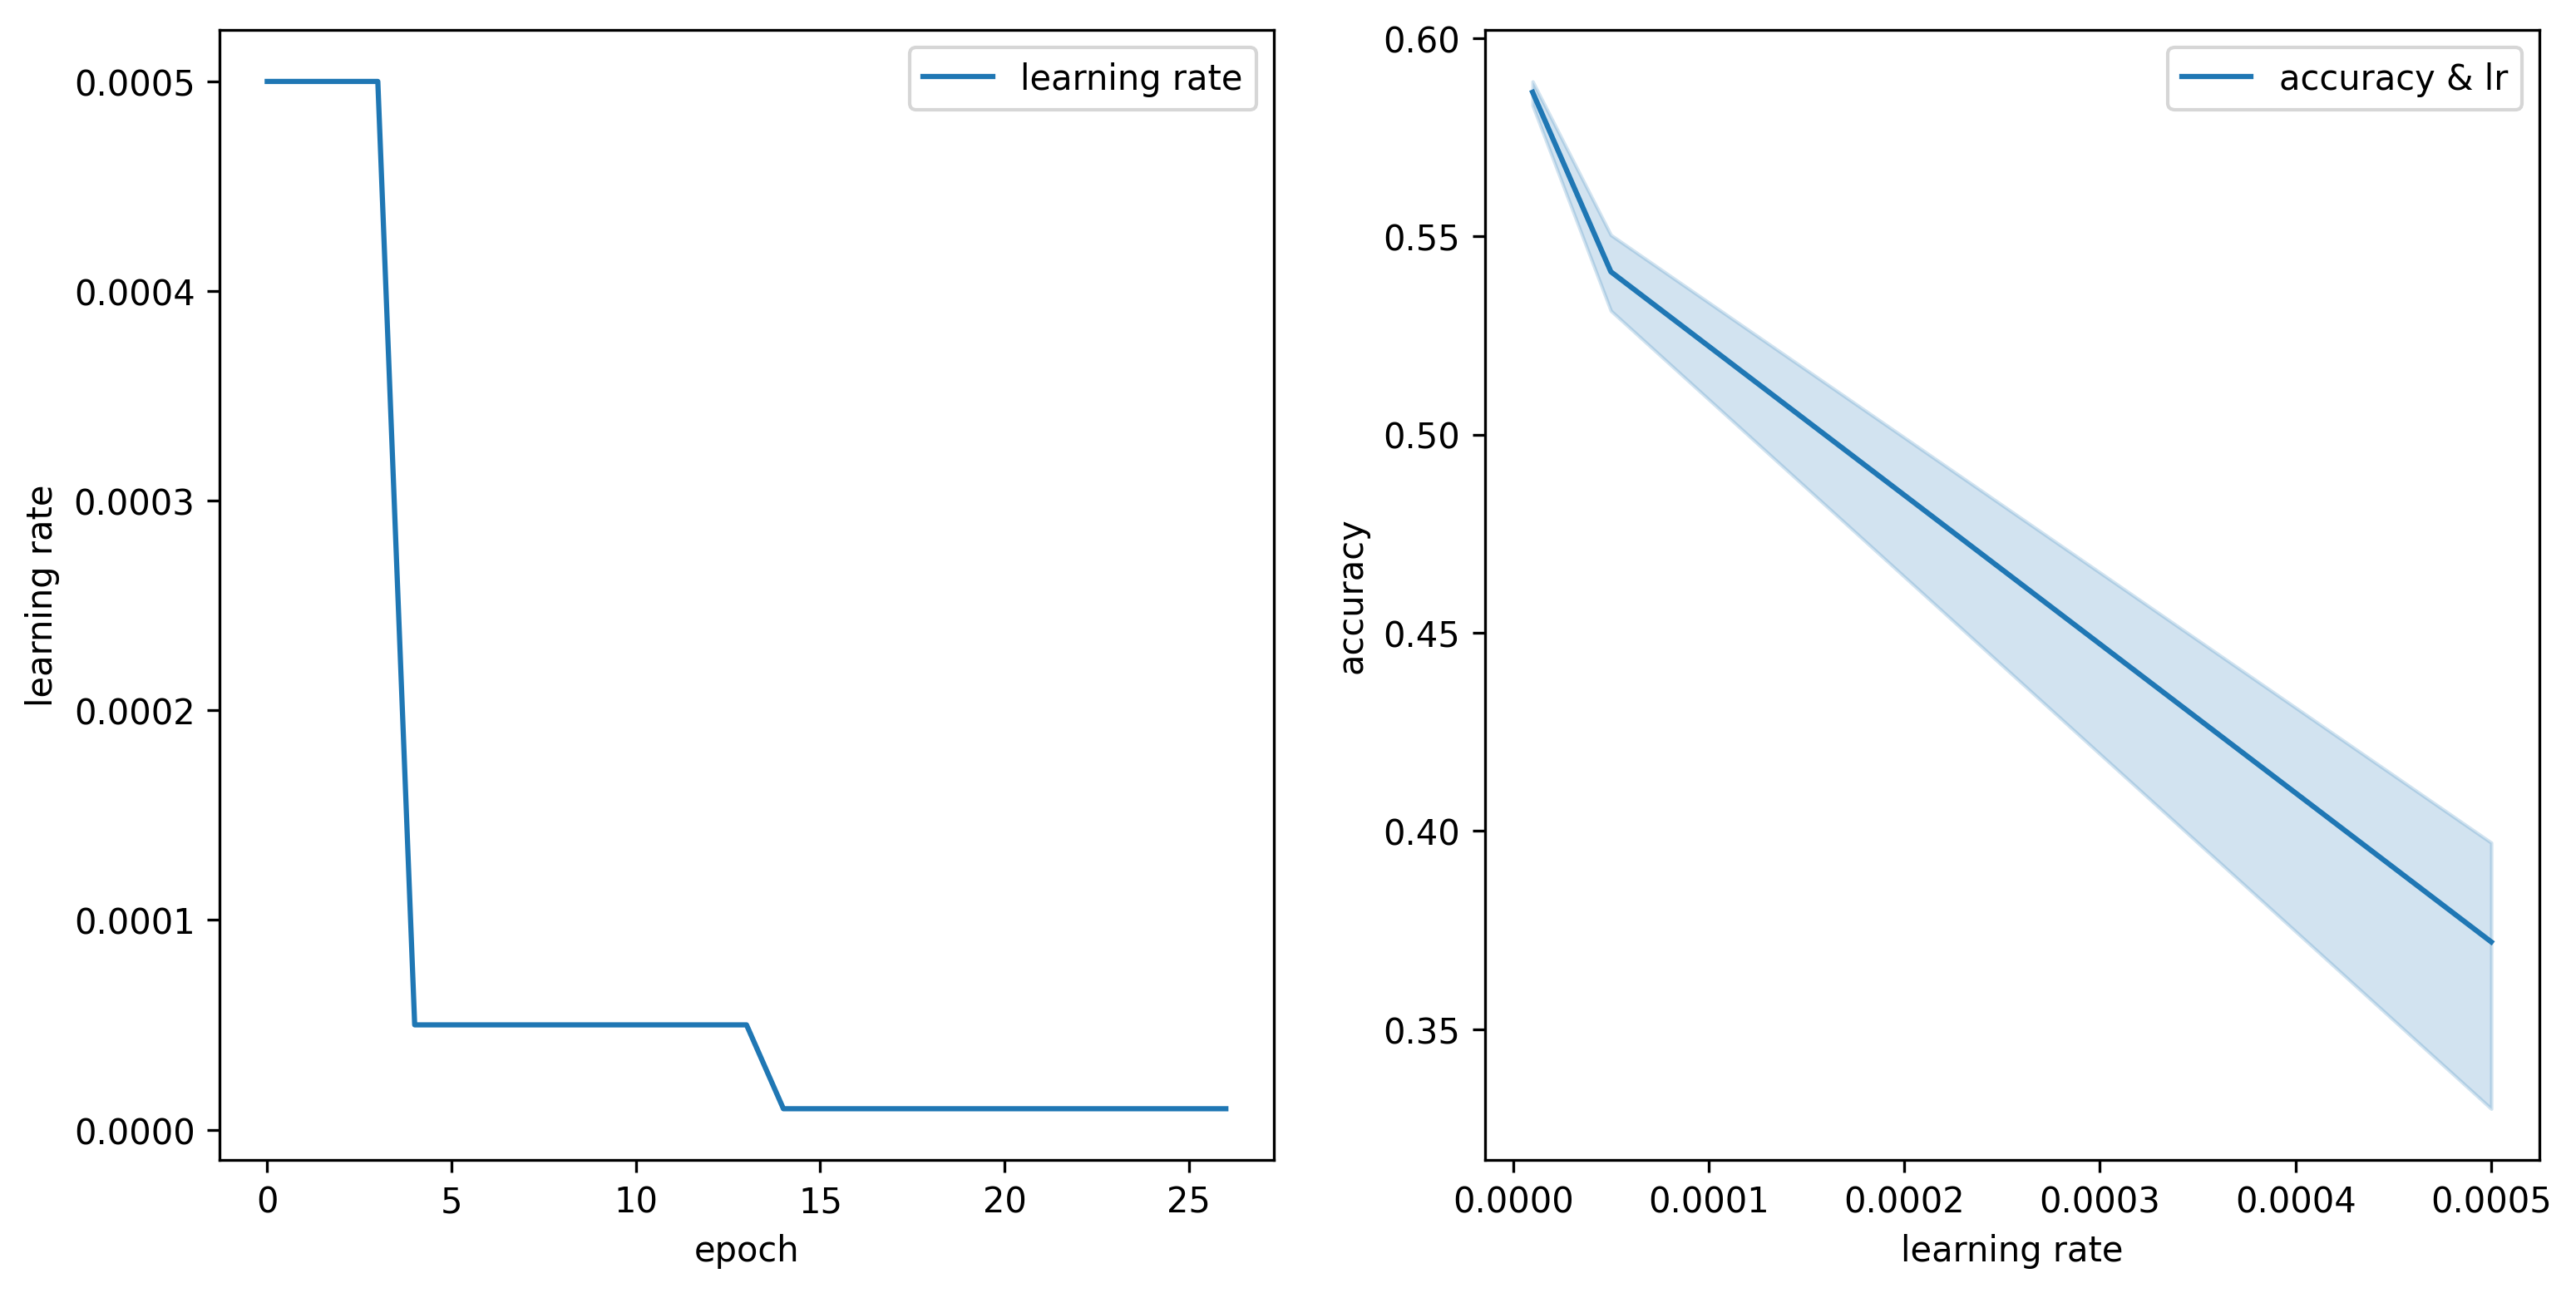

In [11]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=epochs, y=history.history['lr'], ax=axes[0], label='learning rate')
sns.lineplot(x=history.history['lr'], y=history.history['val_accuracy'], ax=axes[1], label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('FER_VGG_lr_history.png')
plt.show()

In [12]:
model.evaluate(validation_gen)

90/90 [==============================] - 4s 48ms/step - loss: 1.0944 - accuracy: 0.5919


[1.0943820476531982, 0.5918829441070557]